<h3 align="center"><b> PySpark Group & Join Test </b></h3>

---

In [1]:
import re, pandas as pd, pyspark, seaborn as sns
from time import time

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import IntegerType, StructType, StructField

sns.set()
print(pyspark.__version__)

3.2.2


In [2]:
conf = (SparkConf()
         .setMaster("local")
         .setAppName("dev")
         .set("spark.executor.memory", "1g"))

sc = SparkContext(conf = conf)
spark = SparkSession(sparkContext=sc)

<h4 align="center"><b> Pandas Version </b></h4>

---

In [3]:
# Option 1
start = time()
df = pd.read_csv(r'../data/random.csv')

df_schema = StructType([StructField(col, IntegerType(), True) for col in df.columns])
df = spark.createDataFrame(df, schema=df_schema)

print(f"Rows: {df.count()}")
print(f"Columns: {len(df.columns)}")
print("Schema:")
df.printSchema()

Rows: 819200
Columns: 6
Schema:
root
 |-- iter: integer (nullable = true)
 |-- t1: integer (nullable = true)
 |-- t2: integer (nullable = true)
 |-- t3: integer (nullable = true)
 |-- t4: integer (nullable = true)
 |-- t5: integer (nullable = true)



In [4]:
# Create Column Profiles
iter_cols = [i for i in df.columns if re.match('t[0-9]', i)]

for col in iter_cols:
    df = df.withColumn('key', F.concat_ws('_', F.col('iter'), F.col(col)))

    if col == iter_cols[0]:
        counter = df.groupBy('key').count().withColumnRenamed('count', col).toPandas()
    else:
        temp = df.groupBy('key').count().withColumnRenamed('count', col).toPandas().set_index('key')[col].to_dict()
        counter[col] = counter['key'].map(temp)

counter['iter'] = [int(i.split('_')[0]) for i in counter['key']]
counter['age'] = [int(i.split('_')[1]) for i in counter['key']]
counter = counter[['age', *iter_cols]].copy().fillna(0)

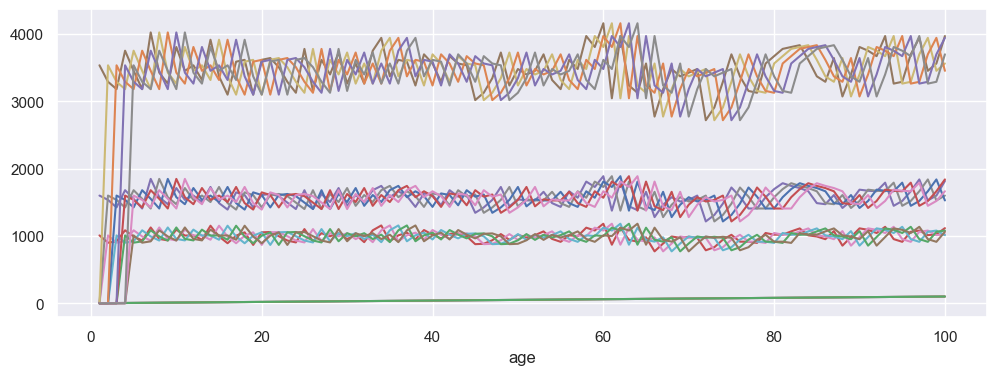

In [5]:
# Plot P10 - P90
pdf = counter.copy()

for col in pdf.columns:
    pdf.groupby('age')[col].quantile(0.1).astype(int).plot(figsize=(12,4))
    pdf.groupby('age')[col].quantile(0.5).astype(int).plot(figsize=(12,4))
    pdf.groupby('age')[col].quantile(0.9).astype(int).plot(figsize=(12,4))

In [6]:
lap = time()
print(round(lap - start))

29


<h4 align="center"><b> Spark Version </b></h4>

---

In [7]:
# Option 2
df = spark.read.csv('../data/random.csv', header=True, inferSchema=True)

print(f"Rows: {df.count()}")
print(f"Columns: {len(df.columns)}")
print("Schema:")
df.printSchema()

Rows: 819200
Columns: 6
Schema:
root
 |-- iter: integer (nullable = true)
 |-- t1: integer (nullable = true)
 |-- t2: integer (nullable = true)
 |-- t3: integer (nullable = true)
 |-- t4: integer (nullable = true)
 |-- t5: integer (nullable = true)



In [8]:
# Create Column Profiles
iter_cols = [i for i in df.columns if re.match('t[0-9]', i)]

for col in iter_cols:
    df = df.withColumn('key', F.concat_ws('_', F.col('iter'), F.col(col)))

    if col == iter_cols[0]:
        counter = df.groupBy('key').count().withColumnRenamed('count', col)
    else:
        counter = counter.join(
            df.groupBy('key').count(), 
            on='key', 
            how='outer',
            ).withColumnRenamed('count', col)

counter = counter.withColumn('iter', F.substring('key', 1, 1).cast(IntegerType()))
counter = counter.withColumn('age', F.substring('key', 3, 3).cast(IntegerType()))
counter = counter.drop('key', 'iter')

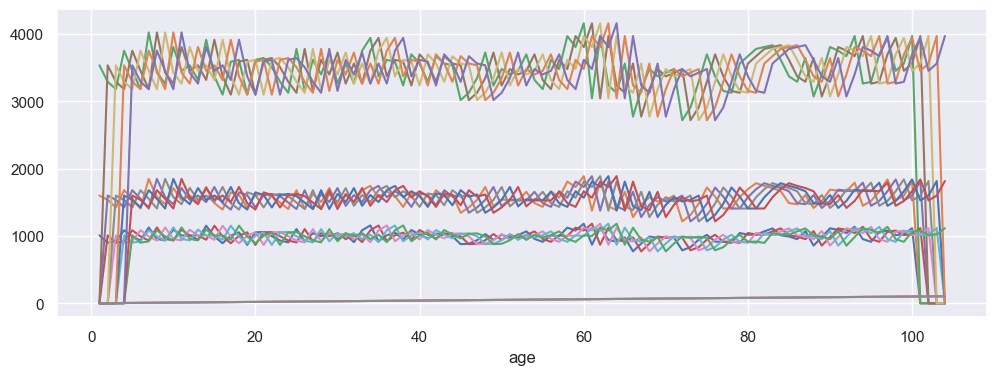

In [9]:
# Plot P10 - P90
pdf = counter.toPandas().fillna(0)

for col in pdf.columns:
    pdf.groupby('age')[col].quantile(0.1).astype(int).plot(figsize=(12,4))
    pdf.groupby('age')[col].quantile(0.5).astype(int).plot(figsize=(12,4))
    pdf.groupby('age')[col].quantile(0.9).astype(int).plot(figsize=(12,4))

In [10]:
last_lap = time()
print(round(last_lap - lap))

21


In [11]:
spark.stop()